In [2]:
import pandas as pd
import os
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LSTM
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def load_data(dataset_path='./npy_files'):
    X = np.load(os.path.join(dataset_path,'X.npy'))
    y = np.load(os.path.join(dataset_path,'y.npy'))
    folds = np.load(os.path.join(dataset_path,'folds.npy'))
    feature_class = np.load(os.path.join(dataset_path, 'feature_class.npy'))
    facs = pd.read_csv('save_data/npy_files/facs_multi.csv',index_col=None)

    # rescale [0,255] -> [0,2]    
    X = X.astype('float32')/255*2

    # one-hot encode the labels
    num_classes = len(np.unique(y))
    y = keras.utils.to_categorical(y, num_classes)

    return X, y, folds, feature_class, facs

In [4]:
X, y, folds, feature_class, facs = load_data('./save_data/npy_files/')

In [5]:
del facs['Unnamed: 0']

In [155]:
del facs['10']

In [156]:
del facs['26']

In [157]:
facs

,0,1,2,4,5,6,7,9,12,15,17,20,23,24,25,27
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [158]:
from sklearn.model_selection import train_test_split

In [7]:
feature_class_single = np.zeros((1307, 4040))
for index, inst in enumerate(feature_class):
    feature_class_single[index] = inst[0]

In [162]:
feature_train, feature_test, facs_train, facs_test = \
        train_test_split(feature_class_single, facs, test_size=0.2)

In [159]:
def make_model():
    inputs = Input(shape=(4040,))
    h1 = Dense(1000, activation='relu')(inputs)
    h2 = Dense(500, activation='relu')(inputs)
    prediction = Dense(16, activation='sigmoid')(h2)
    
    dense_model = Model(inputs=inputs, outputs=prediction)
    sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9)
    dense_model.compile(loss='binary_crossentropy', optimizer=sgd,
             metrics=['accuracy'])
    
    return dense_model

In [160]:
dense_model = make_model()

In [167]:
hist = dense_model.fit(feature_train, facs_train, batch_size=64, epochs=1000,
            validation_data=(feature_test, facs_test),
            verbose=2, shuffle=True)

Train on 1045 samples, validate on 262 samples
Epoch 1/1000
 - 0s - loss: 0.0651 - acc: 0.9852 - val_loss: 0.0990 - val_acc: 0.9654
Epoch 2/1000
 - 0s - loss: 0.0650 - acc: 0.9853 - val_loss: 0.0990 - val_acc: 0.9654
Epoch 3/1000
 - 0s - loss: 0.0650 - acc: 0.9853 - val_loss: 0.0989 - val_acc: 0.9654
Epoch 4/1000
 - 0s - loss: 0.0650 - acc: 0.9853 - val_loss: 0.0989 - val_acc: 0.9654
Epoch 5/1000
 - 0s - loss: 0.0650 - acc: 0.9852 - val_loss: 0.0989 - val_acc: 0.9654
Epoch 6/1000
 - 0s - loss: 0.0650 - acc: 0.9852 - val_loss: 0.0989 - val_acc: 0.9654
Epoch 7/1000
 - 0s - loss: 0.0650 - acc: 0.9853 - val_loss: 0.0989 - val_acc: 0.9656
Epoch 8/1000
 - 0s - loss: 0.0650 - acc: 0.9853 - val_loss: 0.0989 - val_acc: 0.9654
Epoch 9/1000
 - 0s - loss: 0.0649 - acc: 0.9852 - val_loss: 0.0989 - val_acc: 0.9656
Epoch 10/1000
 - 0s - loss: 0.0649 - acc: 0.9852 - val_loss: 0.0989 - val_acc: 0.9656
Epoch 11/1000
 - 0s - loss: 0.0649 - acc: 0.9852 - val_loss: 0.0988 - val_acc: 0.9656
Epoch 12/1000
 -

Epoch 96/1000
 - 0s - loss: 0.0638 - acc: 0.9859 - val_loss: 0.0978 - val_acc: 0.9659
Epoch 97/1000
 - 0s - loss: 0.0638 - acc: 0.9858 - val_loss: 0.0978 - val_acc: 0.9659
Epoch 98/1000
 - 0s - loss: 0.0638 - acc: 0.9858 - val_loss: 0.0977 - val_acc: 0.9661
Epoch 99/1000
 - 0s - loss: 0.0638 - acc: 0.9859 - val_loss: 0.0977 - val_acc: 0.9659
Epoch 100/1000
 - 0s - loss: 0.0637 - acc: 0.9859 - val_loss: 0.0977 - val_acc: 0.9659
Epoch 101/1000
 - 0s - loss: 0.0637 - acc: 0.9859 - val_loss: 0.0977 - val_acc: 0.9659
Epoch 102/1000
 - 0s - loss: 0.0637 - acc: 0.9859 - val_loss: 0.0977 - val_acc: 0.9659
Epoch 103/1000
 - 0s - loss: 0.0637 - acc: 0.9859 - val_loss: 0.0977 - val_acc: 0.9659
Epoch 104/1000
 - 0s - loss: 0.0637 - acc: 0.9859 - val_loss: 0.0977 - val_acc: 0.9659
Epoch 105/1000
 - 0s - loss: 0.0637 - acc: 0.9859 - val_loss: 0.0977 - val_acc: 0.9659
Epoch 106/1000
 - 0s - loss: 0.0637 - acc: 0.9859 - val_loss: 0.0976 - val_acc: 0.9659
Epoch 107/1000
 - 0s - loss: 0.0636 - acc: 0.98

Epoch 191/1000
 - 0s - loss: 0.0626 - acc: 0.9865 - val_loss: 0.0966 - val_acc: 0.9666
Epoch 192/1000
 - 0s - loss: 0.0626 - acc: 0.9866 - val_loss: 0.0966 - val_acc: 0.9664
Epoch 193/1000
 - 0s - loss: 0.0626 - acc: 0.9866 - val_loss: 0.0966 - val_acc: 0.9666
Epoch 194/1000
 - 0s - loss: 0.0625 - acc: 0.9866 - val_loss: 0.0966 - val_acc: 0.9664
Epoch 195/1000
 - 0s - loss: 0.0625 - acc: 0.9866 - val_loss: 0.0966 - val_acc: 0.9664
Epoch 196/1000
 - 0s - loss: 0.0625 - acc: 0.9866 - val_loss: 0.0965 - val_acc: 0.9664
Epoch 197/1000
 - 0s - loss: 0.0625 - acc: 0.9866 - val_loss: 0.0965 - val_acc: 0.9664
Epoch 198/1000
 - 0s - loss: 0.0625 - acc: 0.9865 - val_loss: 0.0965 - val_acc: 0.9664
Epoch 199/1000
 - 0s - loss: 0.0625 - acc: 0.9866 - val_loss: 0.0965 - val_acc: 0.9664
Epoch 200/1000
 - 0s - loss: 0.0625 - acc: 0.9866 - val_loss: 0.0965 - val_acc: 0.9664
Epoch 201/1000
 - 0s - loss: 0.0625 - acc: 0.9867 - val_loss: 0.0965 - val_acc: 0.9664
Epoch 202/1000
 - 0s - loss: 0.0624 - acc: 

 - 0s - loss: 0.0614 - acc: 0.9868 - val_loss: 0.0954 - val_acc: 0.9668
Epoch 286/1000
 - 0s - loss: 0.0614 - acc: 0.9869 - val_loss: 0.0954 - val_acc: 0.9673
Epoch 287/1000
 - 0s - loss: 0.0614 - acc: 0.9870 - val_loss: 0.0954 - val_acc: 0.9671
Epoch 288/1000
 - 0s - loss: 0.0614 - acc: 0.9870 - val_loss: 0.0954 - val_acc: 0.9671
Epoch 289/1000
 - 0s - loss: 0.0614 - acc: 0.9870 - val_loss: 0.0954 - val_acc: 0.9671
Epoch 290/1000
 - 0s - loss: 0.0614 - acc: 0.9870 - val_loss: 0.0954 - val_acc: 0.9671
Epoch 291/1000
 - 0s - loss: 0.0614 - acc: 0.9870 - val_loss: 0.0954 - val_acc: 0.9671
Epoch 292/1000
 - 0s - loss: 0.0613 - acc: 0.9870 - val_loss: 0.0954 - val_acc: 0.9668
Epoch 293/1000
 - 0s - loss: 0.0613 - acc: 0.9870 - val_loss: 0.0954 - val_acc: 0.9668
Epoch 294/1000
 - 0s - loss: 0.0613 - acc: 0.9870 - val_loss: 0.0953 - val_acc: 0.9673
Epoch 295/1000
 - 0s - loss: 0.0613 - acc: 0.9870 - val_loss: 0.0953 - val_acc: 0.9673
Epoch 296/1000
 - 0s - loss: 0.0613 - acc: 0.9870 - val_lo

Epoch 380/1000
 - 0s - loss: 0.0603 - acc: 0.9873 - val_loss: 0.0943 - val_acc: 0.9673
Epoch 381/1000
 - 0s - loss: 0.0603 - acc: 0.9873 - val_loss: 0.0943 - val_acc: 0.9673
Epoch 382/1000
 - 0s - loss: 0.0603 - acc: 0.9873 - val_loss: 0.0943 - val_acc: 0.9673
Epoch 383/1000
 - 0s - loss: 0.0603 - acc: 0.9873 - val_loss: 0.0943 - val_acc: 0.9673
Epoch 384/1000
 - 0s - loss: 0.0603 - acc: 0.9873 - val_loss: 0.0943 - val_acc: 0.9676
Epoch 385/1000
 - 0s - loss: 0.0603 - acc: 0.9873 - val_loss: 0.0943 - val_acc: 0.9676
Epoch 386/1000
 - 0s - loss: 0.0602 - acc: 0.9873 - val_loss: 0.0943 - val_acc: 0.9673
Epoch 387/1000
 - 0s - loss: 0.0602 - acc: 0.9873 - val_loss: 0.0943 - val_acc: 0.9673
Epoch 388/1000
 - 0s - loss: 0.0602 - acc: 0.9873 - val_loss: 0.0943 - val_acc: 0.9673
Epoch 389/1000
 - 0s - loss: 0.0602 - acc: 0.9873 - val_loss: 0.0942 - val_acc: 0.9673
Epoch 390/1000
 - 0s - loss: 0.0602 - acc: 0.9873 - val_loss: 0.0942 - val_acc: 0.9676
Epoch 391/1000
 - 0s - loss: 0.0602 - acc: 

Epoch 475/1000
 - 0s - loss: 0.0592 - acc: 0.9879 - val_loss: 0.0933 - val_acc: 0.9676
Epoch 476/1000
 - 0s - loss: 0.0592 - acc: 0.9879 - val_loss: 0.0932 - val_acc: 0.9676
Epoch 477/1000
 - 0s - loss: 0.0592 - acc: 0.9879 - val_loss: 0.0932 - val_acc: 0.9676
Epoch 478/1000
 - 0s - loss: 0.0592 - acc: 0.9879 - val_loss: 0.0932 - val_acc: 0.9676
Epoch 479/1000
 - 0s - loss: 0.0592 - acc: 0.9878 - val_loss: 0.0932 - val_acc: 0.9676
Epoch 480/1000
 - 0s - loss: 0.0592 - acc: 0.9879 - val_loss: 0.0932 - val_acc: 0.9676
Epoch 481/1000
 - 0s - loss: 0.0592 - acc: 0.9878 - val_loss: 0.0932 - val_acc: 0.9676
Epoch 482/1000
 - 0s - loss: 0.0592 - acc: 0.9878 - val_loss: 0.0932 - val_acc: 0.9678
Epoch 483/1000
 - 0s - loss: 0.0592 - acc: 0.9879 - val_loss: 0.0932 - val_acc: 0.9676
Epoch 484/1000
 - 0s - loss: 0.0591 - acc: 0.9879 - val_loss: 0.0932 - val_acc: 0.9676
Epoch 485/1000
 - 0s - loss: 0.0591 - acc: 0.9879 - val_loss: 0.0932 - val_acc: 0.9678
Epoch 486/1000
 - 0s - loss: 0.0591 - acc: 

 - 0s - loss: 0.0582 - acc: 0.9886 - val_loss: 0.0922 - val_acc: 0.9685
Epoch 570/1000
 - 0s - loss: 0.0582 - acc: 0.9886 - val_loss: 0.0922 - val_acc: 0.9683
Epoch 571/1000
 - 0s - loss: 0.0582 - acc: 0.9886 - val_loss: 0.0922 - val_acc: 0.9685
Epoch 572/1000
 - 0s - loss: 0.0582 - acc: 0.9886 - val_loss: 0.0922 - val_acc: 0.9685
Epoch 573/1000
 - 0s - loss: 0.0582 - acc: 0.9886 - val_loss: 0.0922 - val_acc: 0.9685
Epoch 574/1000
 - 0s - loss: 0.0582 - acc: 0.9886 - val_loss: 0.0922 - val_acc: 0.9685
Epoch 575/1000
 - 0s - loss: 0.0582 - acc: 0.9886 - val_loss: 0.0921 - val_acc: 0.9685
Epoch 576/1000
 - 0s - loss: 0.0582 - acc: 0.9886 - val_loss: 0.0921 - val_acc: 0.9683
Epoch 577/1000
 - 0s - loss: 0.0581 - acc: 0.9886 - val_loss: 0.0921 - val_acc: 0.9683
Epoch 578/1000
 - 0s - loss: 0.0581 - acc: 0.9887 - val_loss: 0.0921 - val_acc: 0.9685
Epoch 579/1000
 - 0s - loss: 0.0581 - acc: 0.9888 - val_loss: 0.0921 - val_acc: 0.9685
Epoch 580/1000
 - 0s - loss: 0.0581 - acc: 0.9888 - val_lo

Epoch 664/1000
 - 0s - loss: 0.0572 - acc: 0.9891 - val_loss: 0.0912 - val_acc: 0.9688
Epoch 665/1000
 - 0s - loss: 0.0572 - acc: 0.9891 - val_loss: 0.0912 - val_acc: 0.9688
Epoch 666/1000
 - 0s - loss: 0.0572 - acc: 0.9891 - val_loss: 0.0912 - val_acc: 0.9688
Epoch 667/1000
 - 0s - loss: 0.0572 - acc: 0.9891 - val_loss: 0.0912 - val_acc: 0.9688
Epoch 668/1000
 - 0s - loss: 0.0572 - acc: 0.9891 - val_loss: 0.0912 - val_acc: 0.9688
Epoch 669/1000
 - 0s - loss: 0.0572 - acc: 0.9891 - val_loss: 0.0911 - val_acc: 0.9688
Epoch 670/1000
 - 0s - loss: 0.0572 - acc: 0.9891 - val_loss: 0.0911 - val_acc: 0.9685
Epoch 671/1000
 - 0s - loss: 0.0572 - acc: 0.9891 - val_loss: 0.0911 - val_acc: 0.9685
Epoch 672/1000
 - 0s - loss: 0.0572 - acc: 0.9891 - val_loss: 0.0911 - val_acc: 0.9688
Epoch 673/1000
 - 0s - loss: 0.0571 - acc: 0.9891 - val_loss: 0.0911 - val_acc: 0.9685
Epoch 674/1000
 - 0s - loss: 0.0571 - acc: 0.9891 - val_loss: 0.0911 - val_acc: 0.9685
Epoch 675/1000
 - 0s - loss: 0.0571 - acc: 

 - 0s - loss: 0.0563 - acc: 0.9892 - val_loss: 0.0902 - val_acc: 0.9695
Epoch 759/1000
 - 0s - loss: 0.0563 - acc: 0.9892 - val_loss: 0.0902 - val_acc: 0.9695
Epoch 760/1000
 - 0s - loss: 0.0563 - acc: 0.9892 - val_loss: 0.0902 - val_acc: 0.9695
Epoch 761/1000
 - 0s - loss: 0.0563 - acc: 0.9892 - val_loss: 0.0902 - val_acc: 0.9697
Epoch 762/1000
 - 0s - loss: 0.0563 - acc: 0.9893 - val_loss: 0.0902 - val_acc: 0.9695
Epoch 763/1000
 - 0s - loss: 0.0563 - acc: 0.9893 - val_loss: 0.0902 - val_acc: 0.9695
Epoch 764/1000
 - 0s - loss: 0.0562 - acc: 0.9892 - val_loss: 0.0902 - val_acc: 0.9697
Epoch 765/1000
 - 0s - loss: 0.0562 - acc: 0.9893 - val_loss: 0.0901 - val_acc: 0.9697
Epoch 766/1000
 - 0s - loss: 0.0562 - acc: 0.9894 - val_loss: 0.0901 - val_acc: 0.9697
Epoch 767/1000
 - 0s - loss: 0.0562 - acc: 0.9893 - val_loss: 0.0901 - val_acc: 0.9695
Epoch 768/1000
 - 0s - loss: 0.0562 - acc: 0.9893 - val_loss: 0.0901 - val_acc: 0.9695
Epoch 769/1000
 - 0s - loss: 0.0562 - acc: 0.9893 - val_lo

Epoch 853/1000
 - 0s - loss: 0.0554 - acc: 0.9895 - val_loss: 0.0892 - val_acc: 0.9702
Epoch 854/1000
 - 0s - loss: 0.0554 - acc: 0.9895 - val_loss: 0.0892 - val_acc: 0.9699
Epoch 855/1000
 - 0s - loss: 0.0554 - acc: 0.9896 - val_loss: 0.0892 - val_acc: 0.9702
Epoch 856/1000
 - 0s - loss: 0.0554 - acc: 0.9896 - val_loss: 0.0892 - val_acc: 0.9702
Epoch 857/1000
 - 0s - loss: 0.0553 - acc: 0.9896 - val_loss: 0.0892 - val_acc: 0.9699
Epoch 858/1000
 - 0s - loss: 0.0553 - acc: 0.9896 - val_loss: 0.0892 - val_acc: 0.9702
Epoch 859/1000
 - 0s - loss: 0.0553 - acc: 0.9896 - val_loss: 0.0892 - val_acc: 0.9702
Epoch 860/1000
 - 0s - loss: 0.0553 - acc: 0.9896 - val_loss: 0.0892 - val_acc: 0.9702
Epoch 861/1000
 - 0s - loss: 0.0553 - acc: 0.9896 - val_loss: 0.0892 - val_acc: 0.9702
Epoch 862/1000
 - 0s - loss: 0.0553 - acc: 0.9896 - val_loss: 0.0892 - val_acc: 0.9702
Epoch 863/1000
 - 0s - loss: 0.0553 - acc: 0.9896 - val_loss: 0.0892 - val_acc: 0.9702
Epoch 864/1000
 - 0s - loss: 0.0553 - acc: 

 - 0s - loss: 0.0545 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 948/1000
 - 0s - loss: 0.0545 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 949/1000
 - 0s - loss: 0.0545 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 950/1000
 - 0s - loss: 0.0545 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 951/1000
 - 0s - loss: 0.0545 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 952/1000
 - 0s - loss: 0.0545 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 953/1000
 - 0s - loss: 0.0545 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 954/1000
 - 0s - loss: 0.0545 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 955/1000
 - 0s - loss: 0.0544 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 956/1000
 - 0s - loss: 0.0544 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 957/1000
 - 0s - loss: 0.0544 - acc: 0.9898 - val_loss: 0.0883 - val_acc: 0.9702
Epoch 958/1000
 - 0s - loss: 0.0544 - acc: 0.9898 - val_lo

In [214]:
hist.history['acc']

[0.9852272728983865,
 0.9852870807693336,
 0.9852870815108268,
 0.985287081282675,
 0.985167464571136,
 0.9852272728983865,
 0.9852870808263715,
 0.9852870810545232,
 0.9851674635444532,
 0.9852272722139312,
 0.9852272729554244,
 0.9851674645140981,
 0.9851674645140981,
 0.9852272724420831,
 0.9852272726702348,
 0.9851674636014911,
 0.9851674635444532,
 0.9852272728983865,
 0.985287081282675,
 0.9852272728983865,
 0.9852870815678647,
 0.9852870807693336,
 0.9852870815108268,
 0.985287081225637,
 0.985287081282675,
 0.9852272722139312,
 0.9852870815108268,
 0.9852870817389785,
 0.9853468896669634,
 0.9853468904084566,
 0.9853468898951152,
 0.9853468894388117,
 0.9854665071199955,
 0.9854665068918438,
 0.9854665068918438,
 0.9854665074051853,
 0.9854665068918438,
 0.9854665074051853,
 0.9855263161887392,
 0.9854665068918438,
 0.9854665068918438,
 0.9855263161887392,
 0.9854665073481473,
 0.9855263159605875,
 0.9855263162457771,
 0.9855263152761322,
 0.9855263152190943,
 0.985526315504284

In [168]:
facs_pred = dense_model.predict(feature_test)

In [169]:
facs_pred

array([[8.7661743e-02, 3.2440864e-04, 1.0446651e-03, ..., 1.4425850e-02,
        9.6163571e-01, 3.5935859e-04],
       [6.5452498e-01, 2.4775972e-03, 9.7125210e-03, ..., 1.6262464e-02,
        2.1230895e-03, 4.2881514e-03],
       [3.9849889e-05, 4.2659612e-03, 4.5954785e-04, ..., 8.3561850e-01,
        1.1862071e-03, 2.6005348e-03],
       ...,
       [1.1779800e-03, 7.4366957e-04, 8.7815293e-05, ..., 2.4802882e-02,
        8.6013961e-01, 2.4643272e-05],
       [3.4393440e-04, 7.3262893e-02, 2.6843983e-03, ..., 1.2463920e-02,
        3.7806530e-02, 2.8556609e-03],
       [4.1195294e-03, 9.9360317e-01, 9.2754835e-01, ..., 2.1483595e-03,
        9.5155293e-01, 5.5079561e-01]], dtype=float32)

In [170]:
facs_pred_int = []
for inst in facs_pred:
    temp_inst = []
    for elem in inst:
        if elem > 0.5:
            temp_inst.append(1)
        else:
            temp_inst.append(0)
    facs_pred_int.append(temp_inst)

In [171]:
facs.columns[0]

'0'

In [172]:
facs_test.values.shape

(262, 16)

In [173]:
facs_pred_np = np.array(facs_pred_int, dtype=int)

In [174]:
facs_accuracy = {}
for code_num in facs.columns:
    facs_accuracy[int(code_num)] = 0

In [175]:
for i in range(facs_pred_np.shape[0]):
    for j in range(facs_pred_np.shape[1]):
        if facs_pred_np[i][j] == facs_test.values[i][j]:
            facs_accuracy[int(facs.columns[j])] +=1

In [178]:
facs_accuracy = pd.DataFrame(facs_accuracy, index=range(1))

In [179]:
facs_acc_percent = facs_accuracy.applymap(lambda x : x /262*100)

In [180]:
facs_acc_percent = facs_acc_percent.T

In [181]:
facs_acc_percent.columns = ['Accuracy']

In [182]:
facs_pred_df = pd.DataFrame(facs_pred_np, columns=facs.columns)

In [183]:
facs_test_arranged = facs_test.astype(np.int)
facs_test_arranged.index = range(facs_test_arranged.shape[0])

In [204]:
from sklearn.metrics import f1_score
facs_f1_score = {}
for code_num in facs_pred_df.columns:    
    facs_f1_score[int(code_num)] = f1_score(facs_test_arranged[code_num], facs_pred_df[code_num])

In [205]:
facs_f1_score = pd.DataFrame(facs_f1_score, index=['f1_score'])

In [208]:
facs_f1_score = facs_f1_score.T

In [210]:
facs_f1_score['f1_score'].map(lambda x : x * 100)

0     96.666667
1     97.076023
2     94.573643
4     91.428571
5     98.275862
6     87.234043
7     75.000000
9     98.666667
12    95.121951
15    76.470588
17    88.571429
20    96.551724
23    65.384615
24    89.285714
25    98.666667
27    98.148148
Name: f1_score, dtype: float64

In [211]:
facs_acc_percent['f1_score'] = facs_f1_score['f1_score'].map(lambda x : x * 100)

In [212]:
facs_acc_percent

,Accuracy,f1_score
0,98.473282,96.666667
1,98.091603,97.076023
2,97.328244,94.573643
4,95.419847,91.428571
5,99.236641,98.275862
6,95.419847,87.234043
7,90.839695,75.000000
9,99.618321,98.666667
12,98.473282,95.121951
15,96.946565,76.470588


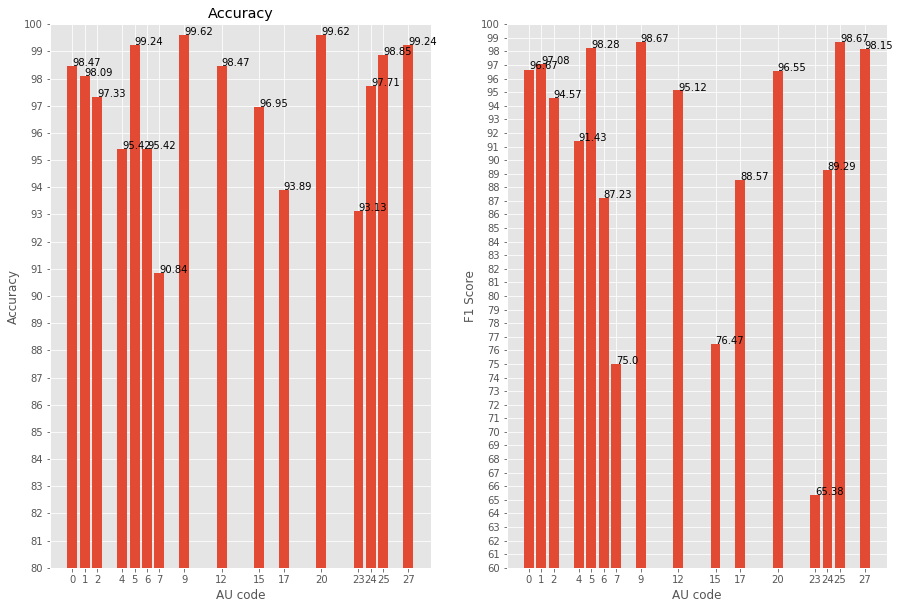

In [222]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('AU code')
plt.ylabel('Accuracy')
plt.xticks(facs_acc_percent.index)
plt.ylim((80,100))
plt.yticks(np.arange(80,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['Accuracy'])
for i,j in zip(list(facs_acc_percent.index), facs_acc_percent['Accuracy']):
    j = round(j, 2)
    ax.annotate(str(j),xy=(i,j))


ax = plt.subplot(1,2,2)
plt.xlabel('AU code')
plt.ylabel('F1 Score')
plt.xticks(facs_acc_percent.index)
plt.ylim((60,100))
plt.yticks(np.arange(60,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['f1_score'])
for i,j in zip(list(facs_acc_percent.index), facs_acc_percent['f1_score']):
    j = round(j, 2)
    ax.annotate(str(j),xy=(i,j))

In [213]:
facs_acc_percent.to_csv('result/feature_au_acc.csv')

<Container object of 18 artists>

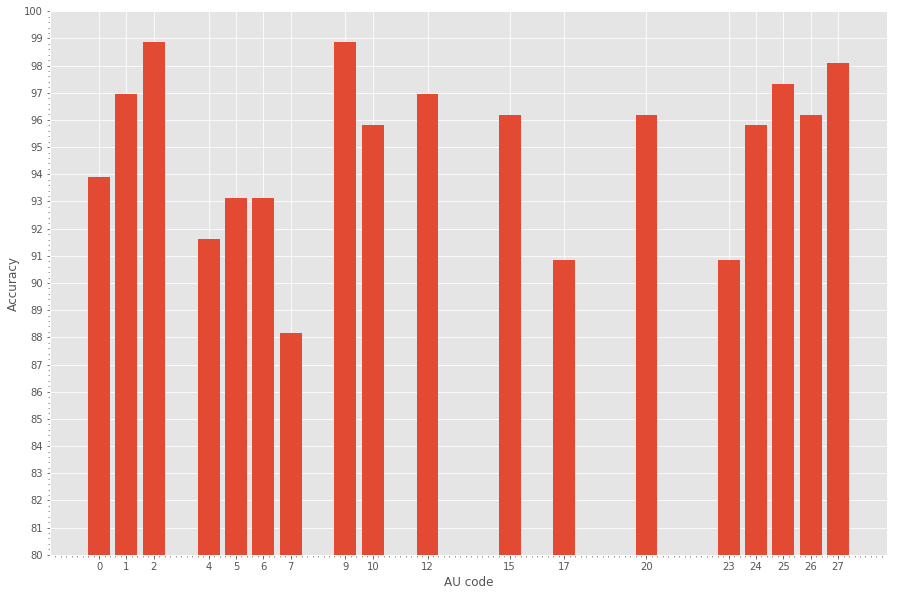

In [128]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
plt.ylabel('Accuracy')
plt.xlabel('AU code')
plt.minorticks_on()
plt.xticks(facs_acc_percent.index)
plt.ylim((80,100))
plt.yticks(np.arange(80,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['Accuracy'])

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rfc = RandomForestClassifier()

In [59]:
rfc.fit(feature_train, facs_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
facs_pred = rfc.predict(feature_test)

In [67]:
facs_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [69]:
facs_test.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [75]:
correct = {}
for inst in range(facs_pred.shape[0]):
    for elem in range(facs_pred.shape[1]):
        if not elem in correct:
            correct[elem] = 0
        if facs_pred[inst][elem] == facs_test.values[inst][elem] and facs_pred[inst][elem] == 1:
            correct[elem] += 1
print(list(map(lambda x : x / facs_pred.shape[0], correct)))

[0.0, 0.003816793893129771, 0.007633587786259542, 0.011450381679389313, 0.015267175572519083, 0.019083969465648856, 0.022900763358778626, 0.026717557251908396, 0.030534351145038167, 0.03435114503816794, 0.03816793893129771, 0.04198473282442748, 0.04580152671755725, 0.04961832061068702, 0.05343511450381679, 0.05725190839694656, 0.061068702290076333, 0.0648854961832061]


## (300,)

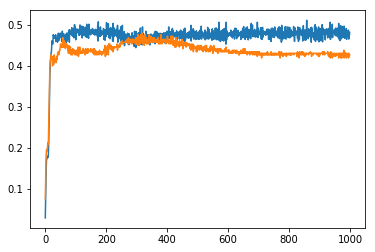

In [49]:
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000,)

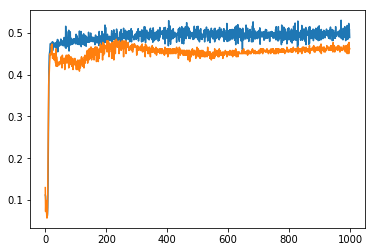

In [53]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000, 500)

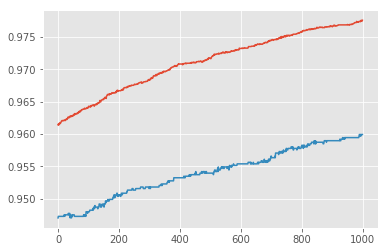

In [165]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])